In [0]:
#link to the raw location of the file on which you want to test the models
raw_link_to_github_file = 'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_no_noise.csv'

In [0]:
debug = False
window = [1, 3]

import warnings
warnings.filterwarnings('ignore')

<bound method NDFrame.head of                 timestamp     value
0     2014-04-01 00:00:00  20.00000
1     2014-04-01 00:05:00  20.00000
2     2014-04-01 00:10:00  20.00000
3     2014-04-01 00:15:00  20.00000
4     2014-04-01 00:20:00  20.00000
...                   ...       ...
4027  2014-04-14 23:35:00  20.00384
4028  2014-04-14 23:40:00  20.00384
4029  2014-04-14 23:45:00  20.00384
4030  2014-04-14 23:50:00  20.00384
4031  2014-04-14 23:55:00  20.00384

[4032 rows x 2 columns]>


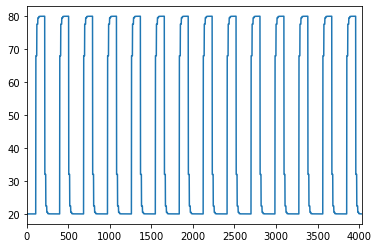

In [106]:
import pandas as pd

df = pd.read_csv(raw_link_to_github_file)
if(debug): 
  print(df.head)

df['value'].plot()
np_arr = df.values

In [107]:
split_percentage = 0.75

train = np_arr[:int(np_arr.shape[0]*split_percentage),:]
test = np_arr[int(np_arr.shape[0]*split_percentage):,:]
print('size',np_arr.shape[0])
print('number of examples in train',train.shape[0])
print('number of examples in test',test.shape[0])

if(debug):
  print(train)
  print(test)
  

size 4032
number of examples in train 3024
number of examples in test 1008
[['2014-04-01 00:00:00' 20.0]
 ['2014-04-01 00:05:00' 20.0]
 ['2014-04-01 00:10:00' 20.0]
 ...
 ['2014-04-11 11:45:00' 79.52]
 ['2014-04-11 11:50:00' 79.52]
 ['2014-04-11 11:55:00' 79.52]]
[['2014-04-11 12:00:00' 79.904]
 ['2014-04-11 12:05:00' 79.904]
 ['2014-04-11 12:10:00' 79.904]
 ...
 ['2014-04-14 23:45:00' 20.003839998]
 ['2014-04-14 23:50:00' 20.003839998]
 ['2014-04-14 23:55:00' 20.003839998]]


In [0]:
import numpy as np

if(debug):
  df_log = np.log(df['value'])
  df_log.plot()

In [0]:
#this is a stationary data
#for a non-stationary data, to make is stationary, we can apply methods like
# - subtracting mean from it
# - subtracting exponential decay
# - subtract every the point by the one that preceded it

#need to impliment this

In [0]:
#ARIMA Auto Regression, moving average with autocoversion of time series into stationary by taking approach 3
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt

arima_mse_per_window = list()
arima_predictions = list()

for w in window:
  history = [x for x in train[:,1]]
  arima_prediction = list()
  for t in range(0,len(test[:,1]),w):
    model = ARIMA(history, order=(5,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0:w]
    pred = [v.flatten() for v in yhat]
    pred = np.concatenate(pred).ravel()
    arima_prediction.extend(pred[0:w])
    obs = test[t:t+w,1]
    history.extend(obs)
    if(debug):
      print('predicted=',pred)
      print('expected=',obs)
  arima_predictions.append(arima_prediction)
  arima_mse_per_window.append(mean_squared_error(test[:,1], arima_prediction))
  plt.plot(arima_predictions, label=str(w))
  plt.legend()
plt.plot(test[:,1],label='actual')
plt.legend()
plt.show()
  

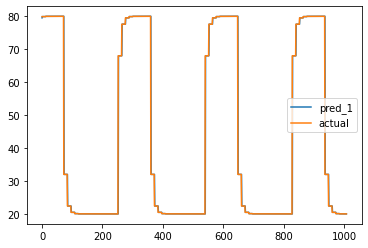

In [141]:
plt.plot(arima_predictions[0], label='pred_1')
#plt.plot(arima_predictions[1], label='3')
plt.plot(test[:,1],label='actual')
plt.legend()
plt.show()

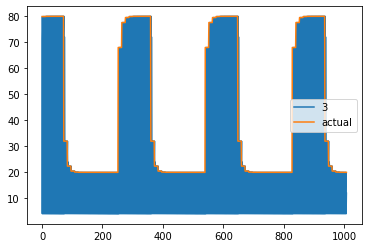

In [139]:
plt.plot(arima_predictions[1], label='pred_3')
plt.plot(test[:,1],label='actual')
plt.legend()
plt.show()

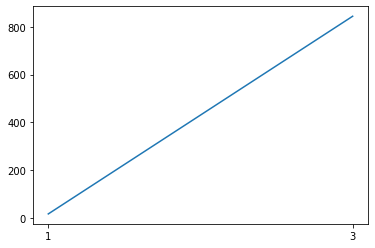

In [146]:
plt.plot([1,3],arima_mse_per_window)
plt.xticks([1,3])
plt.show()

In [0]:
#Prophet FB model
from fbprophet import Prophet
import pandas as pd

prophet_mse_per_window = list()
prophet_predictions = list()

for w in window:
  history = history = pd.DataFrame(data=train,columns=['ds','y'])
  prophet_prediction = list()
  for t in range(0,len(test[:,1]),window[1]):
    model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
    model.fit(history)
    future = model.make_future_dataframe(periods=int(window[1]),freq='5 MIN',include_history=False)
    pred = model.predict(future)
    pred_ = pred['yhat'][:window[1]]
    prophet_prediction.extend(pred_.values.tolist())

    act = test[t:t+window[1],:]
    next_ = pd.DataFrame(data=act,columns=['ds','y'])

    history = history.append(next_,ignore_index=True)
    if(debug):
      print('predicted=',pred_.values.tolist())
      print('expected=',act[:,1])
  prophet_mse_per_window.append(mean_squared_error(test[:,1], prophet_prediction))
  prophet_predictions.append(prophet_prediction)

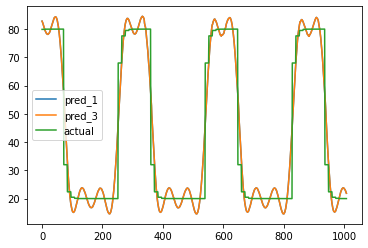

In [143]:
plt.plot(prophet_predictions[0], label='pred_1')
plt.plot(prophet_predictions[1], label='pred_3')
plt.plot(test[:,1],label='actual')
plt.legend()
plt.show()

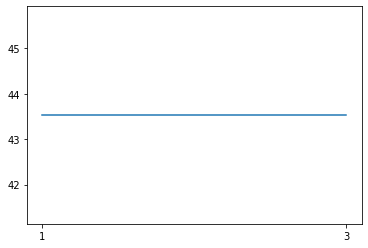

In [145]:
plt.plot([1,3],prophet_mse_per_window)
plt.xticks([1,3])
plt.show()